In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.table import Table
from astropy.io import fits
import astropy.units as u

import vice

In [18]:
import surp

In [22]:
file_name = surp.DATA_DIR + "allStar-dr17-synspec_rev1.fits.1"

In [23]:
ff = fits.open(file_name, mmap=True)
da = ff[1].data
ff.close()

In [25]:
# cuts in W+19
mask = da["LOGG"] > 1
mask &= da["LOGG"] < 2
mask &= da["SNR"] > 80
filtered = da[mask]
# del da

Text(0, 0.5, 'log g')

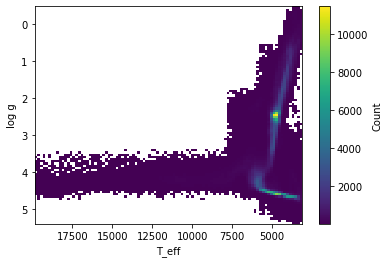

In [6]:
plotting.density_scatter(da["TEFF"], da["LOGG"], density=False)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("T_eff")
plt.ylabel("log g")

In [30]:
df = pd.DataFrame(filtered.tolist(), columns = [c.name for c in filtered.columns])

del filtered
del da

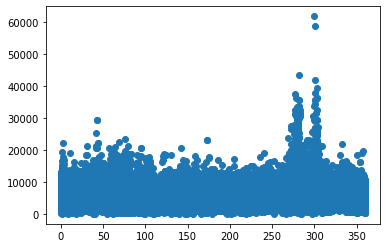

In [8]:
plt.scatter(df["GLON"], df["GAIAEDR3_R_MED_GEO"])

In [31]:
# Calculate galactocentric coordinates
import astropy.coordinates as coord
c = coord.SkyCoord(ra = df["RA"] * u.degree,
                           dec = df["DEC"] * u.degree,
                           distance = df["GAIAEDR3_R_MED_GEO"] * u.pc,
                           frame="icrs")
gc_c = c.transform_to(coord.Galactocentric)


In [53]:
df["R_gal"] = np.array(np.sqrt(gc_c.x**2 + gc_c.y**2) / 1e3)
df["th_gal"] = np.array(np.arctan2(gc_c.y, gc_c.x))
df["abs_z"] = np.array(np.abs(gc_c.z) / 1e3)
df["z"] = np.array(gc_c.z / 1e3)

In [38]:
import arya

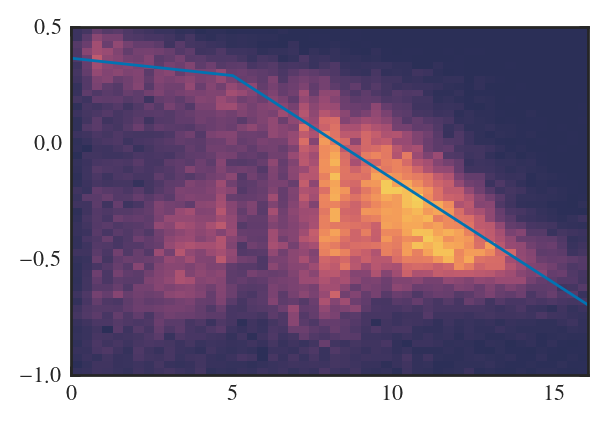

In [52]:
plt.hist2d(df.R_gal, df.M_H, 50, range=([0, 16], [-1, 0.5]));
plt.plot(x, y)

(-10.0, 10.0)

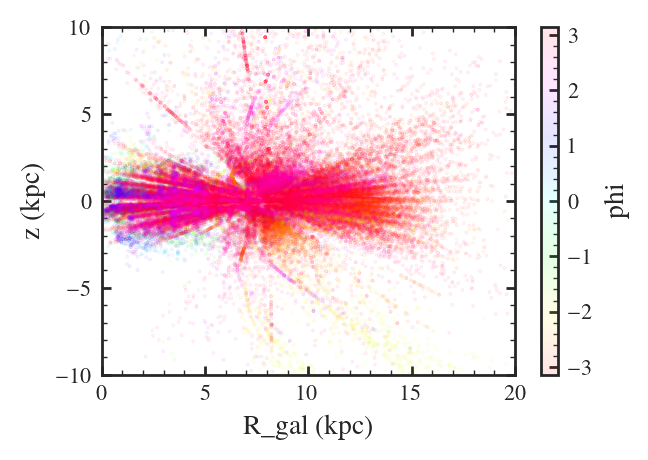

In [54]:
plt.scatter(df.R_gal, df.z, c=df.th_gal, s=0.1, alpha=0.1, cmap="hsv")
plt.colorbar(label="phi")
plt.xlabel("R_gal (kpc)")
plt.ylabel("z (kpc)")
plt.xlim(0, 20)
plt.ylim(-10, 10)

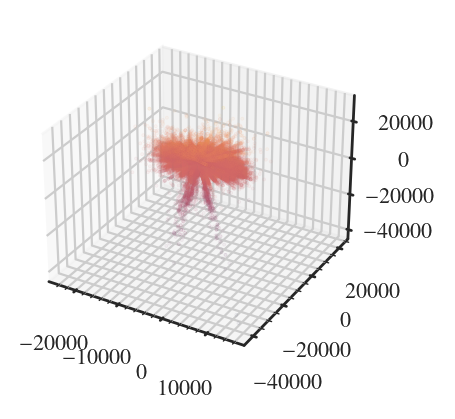

In [55]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(gc_c.x, gc_c.y, gc_c.z, s=0.1, alpha=0.1, c=gc_c.z)

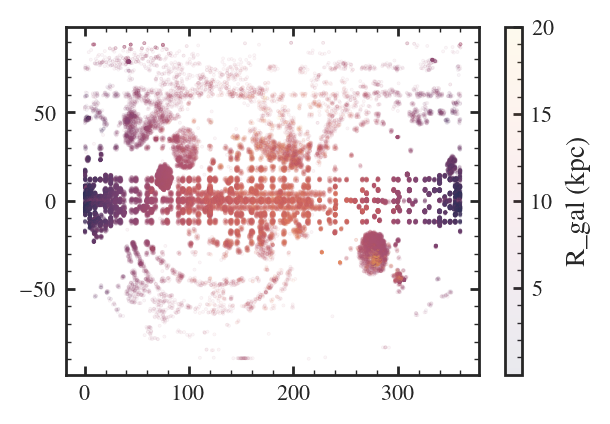

In [56]:
plt.scatter(df["GLON"], df["GLAT"], c=df.R_gal, s=0.1, alpha=0.1, vmax=20)
plt.colorbar(label="R_gal (kpc)")

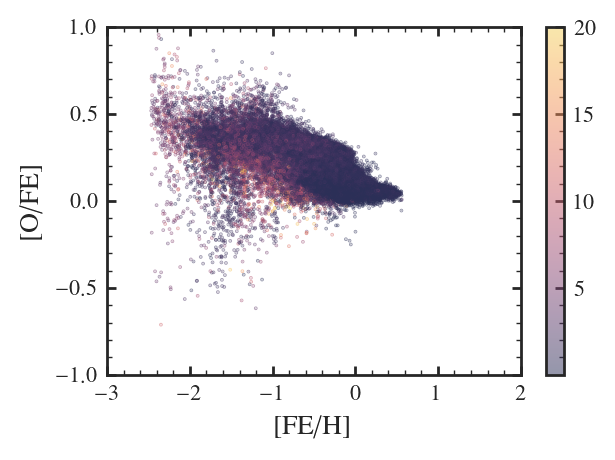

In [59]:
plt.scatter(df["FE_H"], df["O_FE"], c=df.abs_z, s=0.1, alpha=0.5, vmax=20)
plt.ylim(-1,1)
plt.xlim(-3,2)
plt.ylabel("[O/FE]")
plt.xlabel("[FE/H]")
plt.colorbar()

In [83]:
def plot_abundance_alpha(x="FE_H", y="MG_FE", df=df, fig=None, ax=None, s=0.001):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
        
    x_vals = df[x] 
    y_vals = df[y]
    ax.scatter(x_vals[df.high_alpha], y_vals[df.high_alpha], label="low SNIa", alpha=1, s=s)
    ax.scatter(x_vals[~df.high_alpha], y_vals[~df.high_alpha], label="high SNIa", alpha=1, s=s)
    ax.legend(markerscale=0.1/s)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    

In [93]:
df["high_alpha"] = surp.gce_math.is_high_alpha(df["MG_FE"], df["FE_H"])



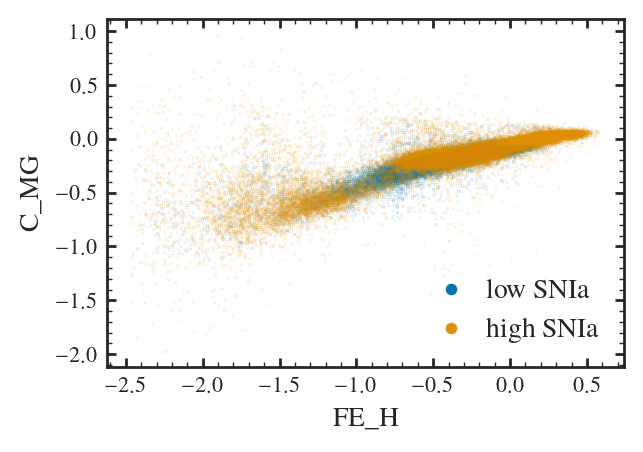

In [99]:
plot_abundance_alpha(y="C_MG")

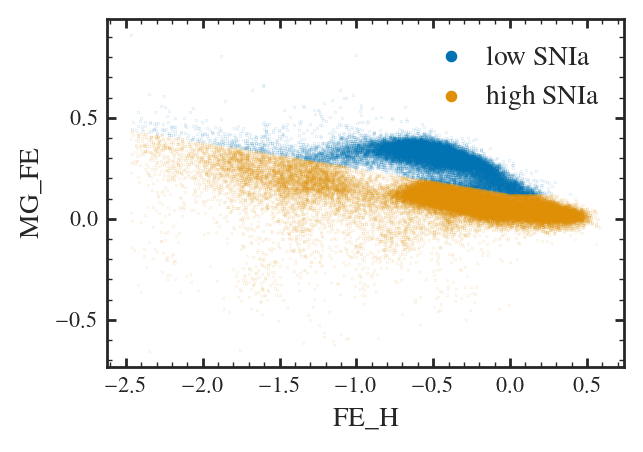

In [94]:
plot_abundance_alpha()

In [95]:
def plot_in_gal_region(x="O_H", y="C_O", split = df, xlabel=None, ylabel=None):
    fig, axs = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(20,15))
    for j in range(5):
        R_min, R_max = [(1, 3), (3, 5), (5,7), (7,9), (9,11), (11,13)][j]
    

        for i in range(3):
            z_min, z_max = [(0, 0.5), (0.5, 1), (1, 2)][i]
            ax = axs[j][i]
            mask = split.R_gal > R_min
            mask &= split.R_gal < R_max
            mask &= split.abs_z > z_min
            mask &= split.abs_z < z_max
            
            # plotting.density_scatter(x[mask], y[mask], fig=fig, ax=ax)
            plot_abundance_alpha(x, y, df = split[mask], fig=fig, ax=ax, s=0.01)
            ax.set_xlabel("")
            ax.set_ylabel("")
            if j==0:
                ax.set(title="z =  %1.1f - %1.1f" % (z_min, z_max))
            if i == 0:
                ax.set_ylabel("R = %i - %i" %(R_min, R_max))
                

                
    fig.supxlabel("[%s/%s]" % tuple(x.split("_")))
    fig.supylabel("[%s/%s]" % tuple(y.split("_")))
            
            


In [97]:
df["C_MG"] = df["C_FE"] - df["MG_FE"]

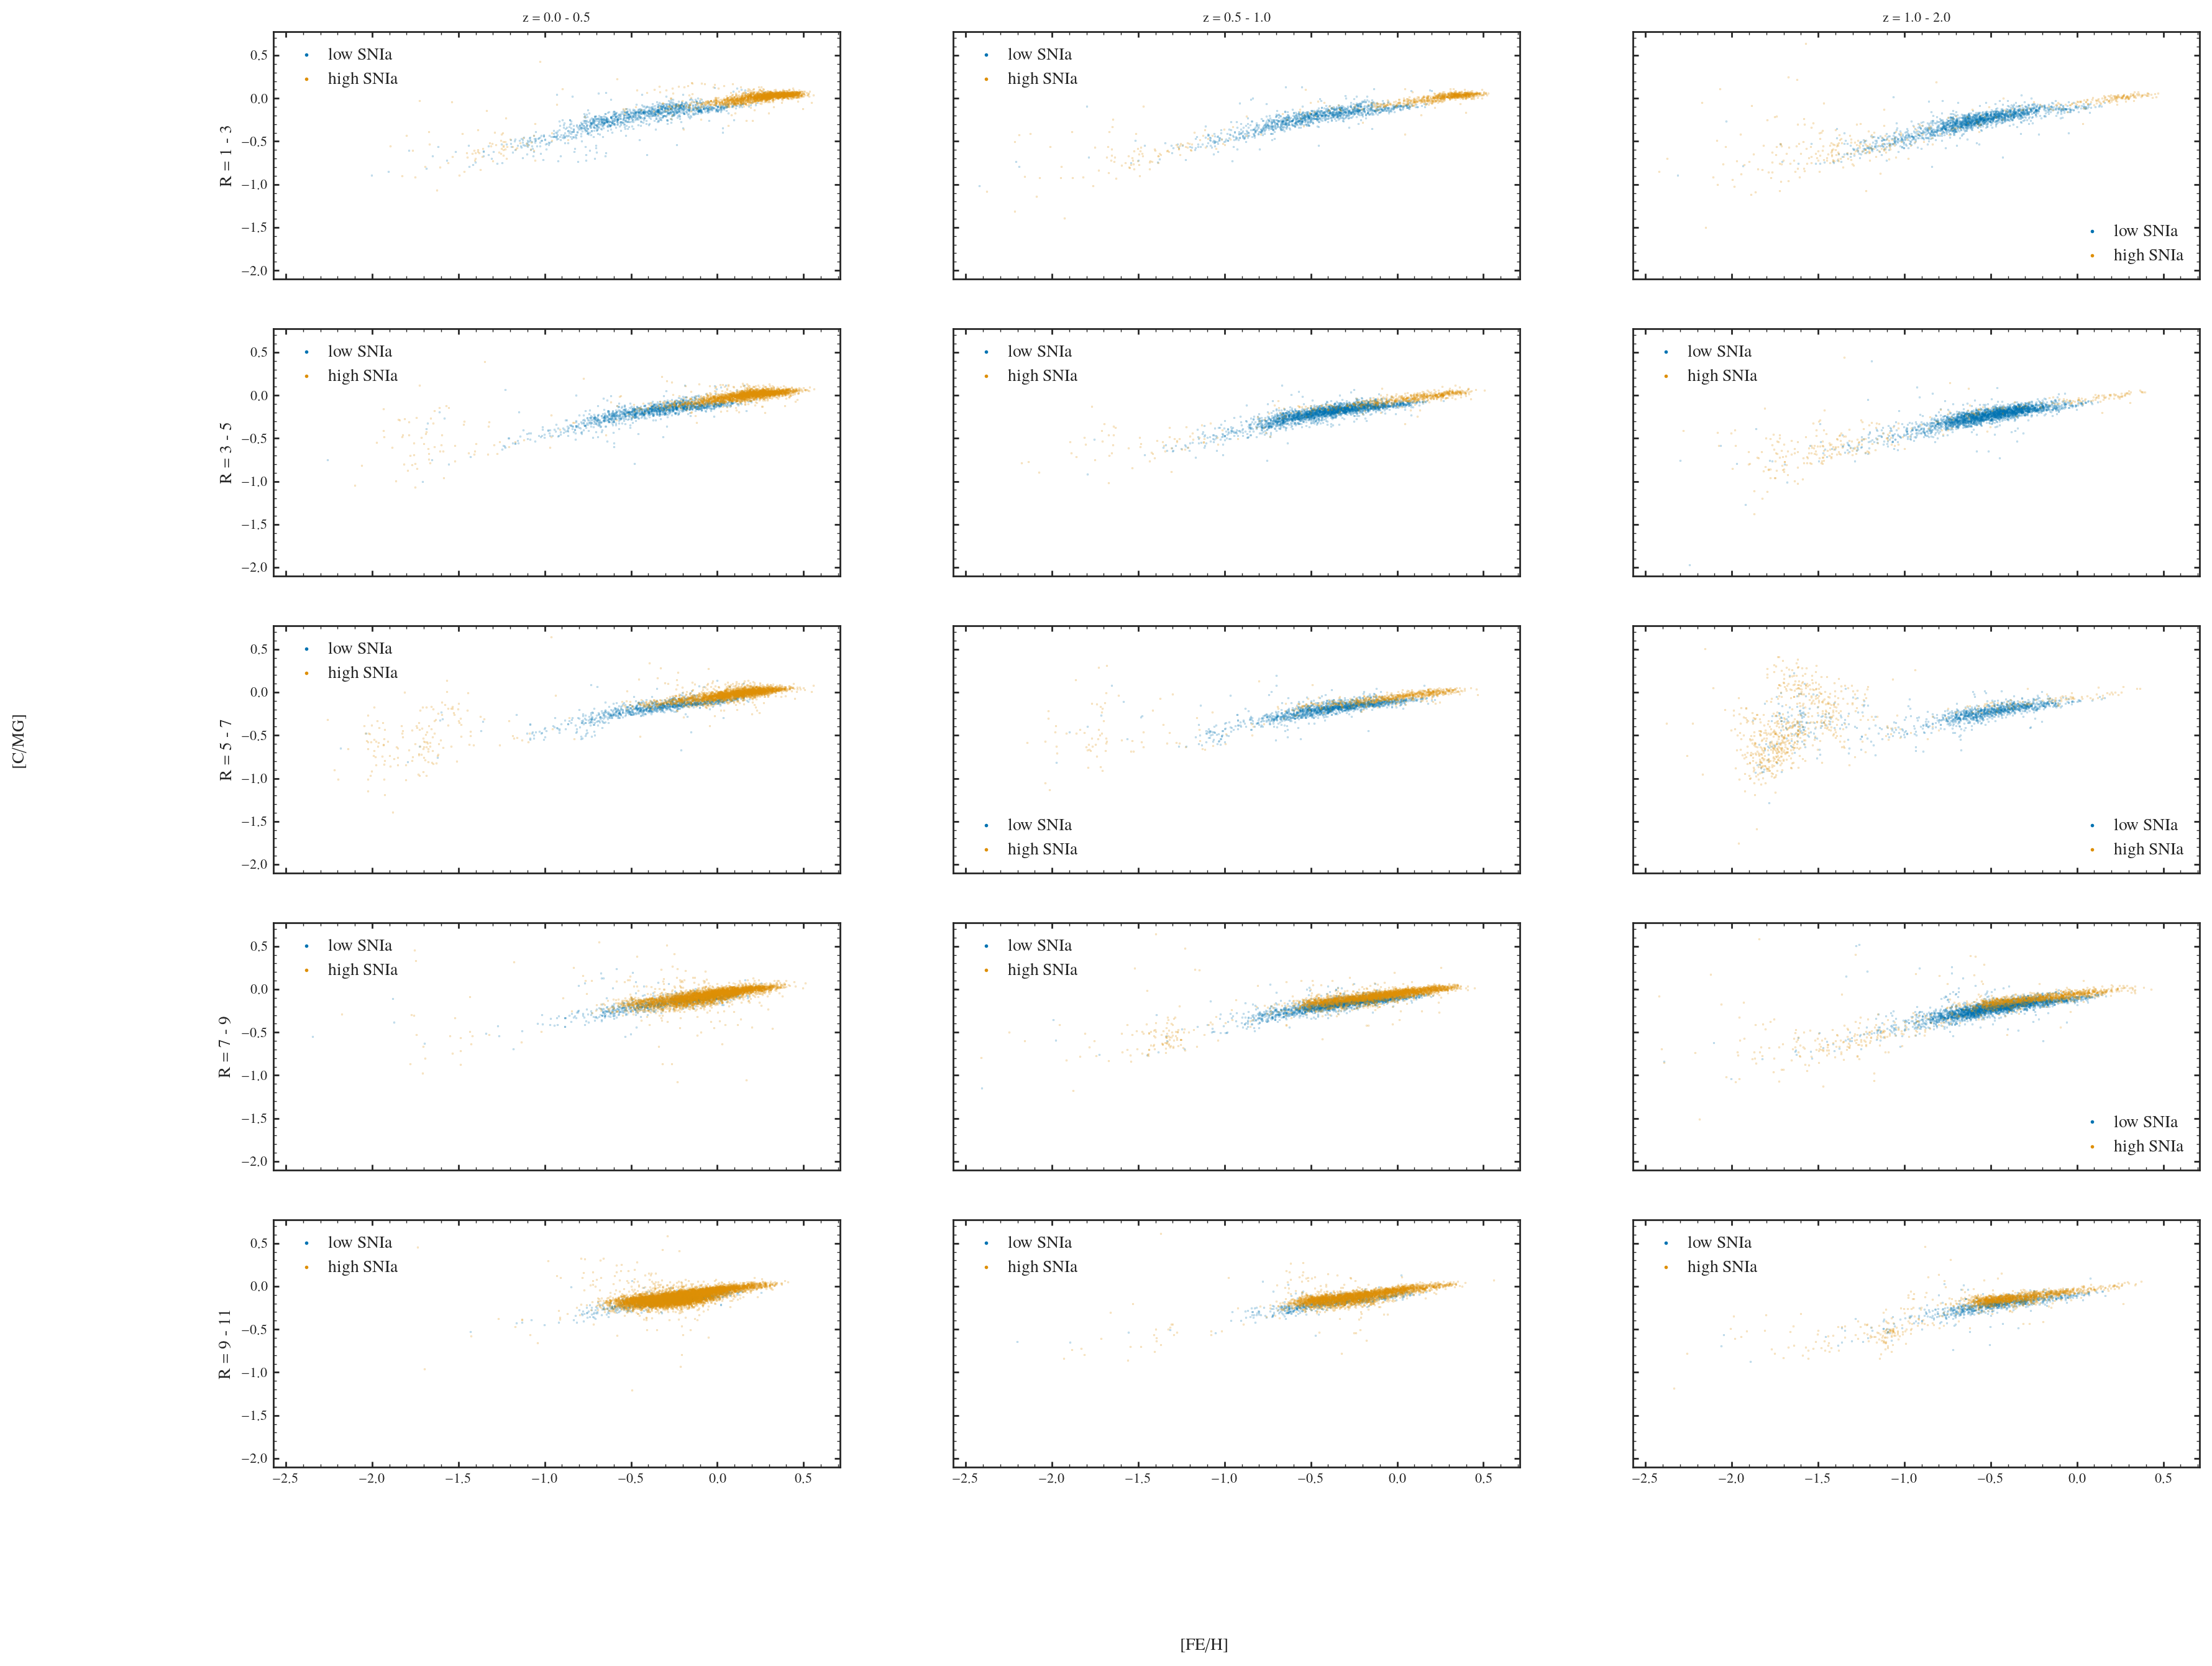

In [98]:
plot_in_gal_region(x = "FE_H", y="C_MG")

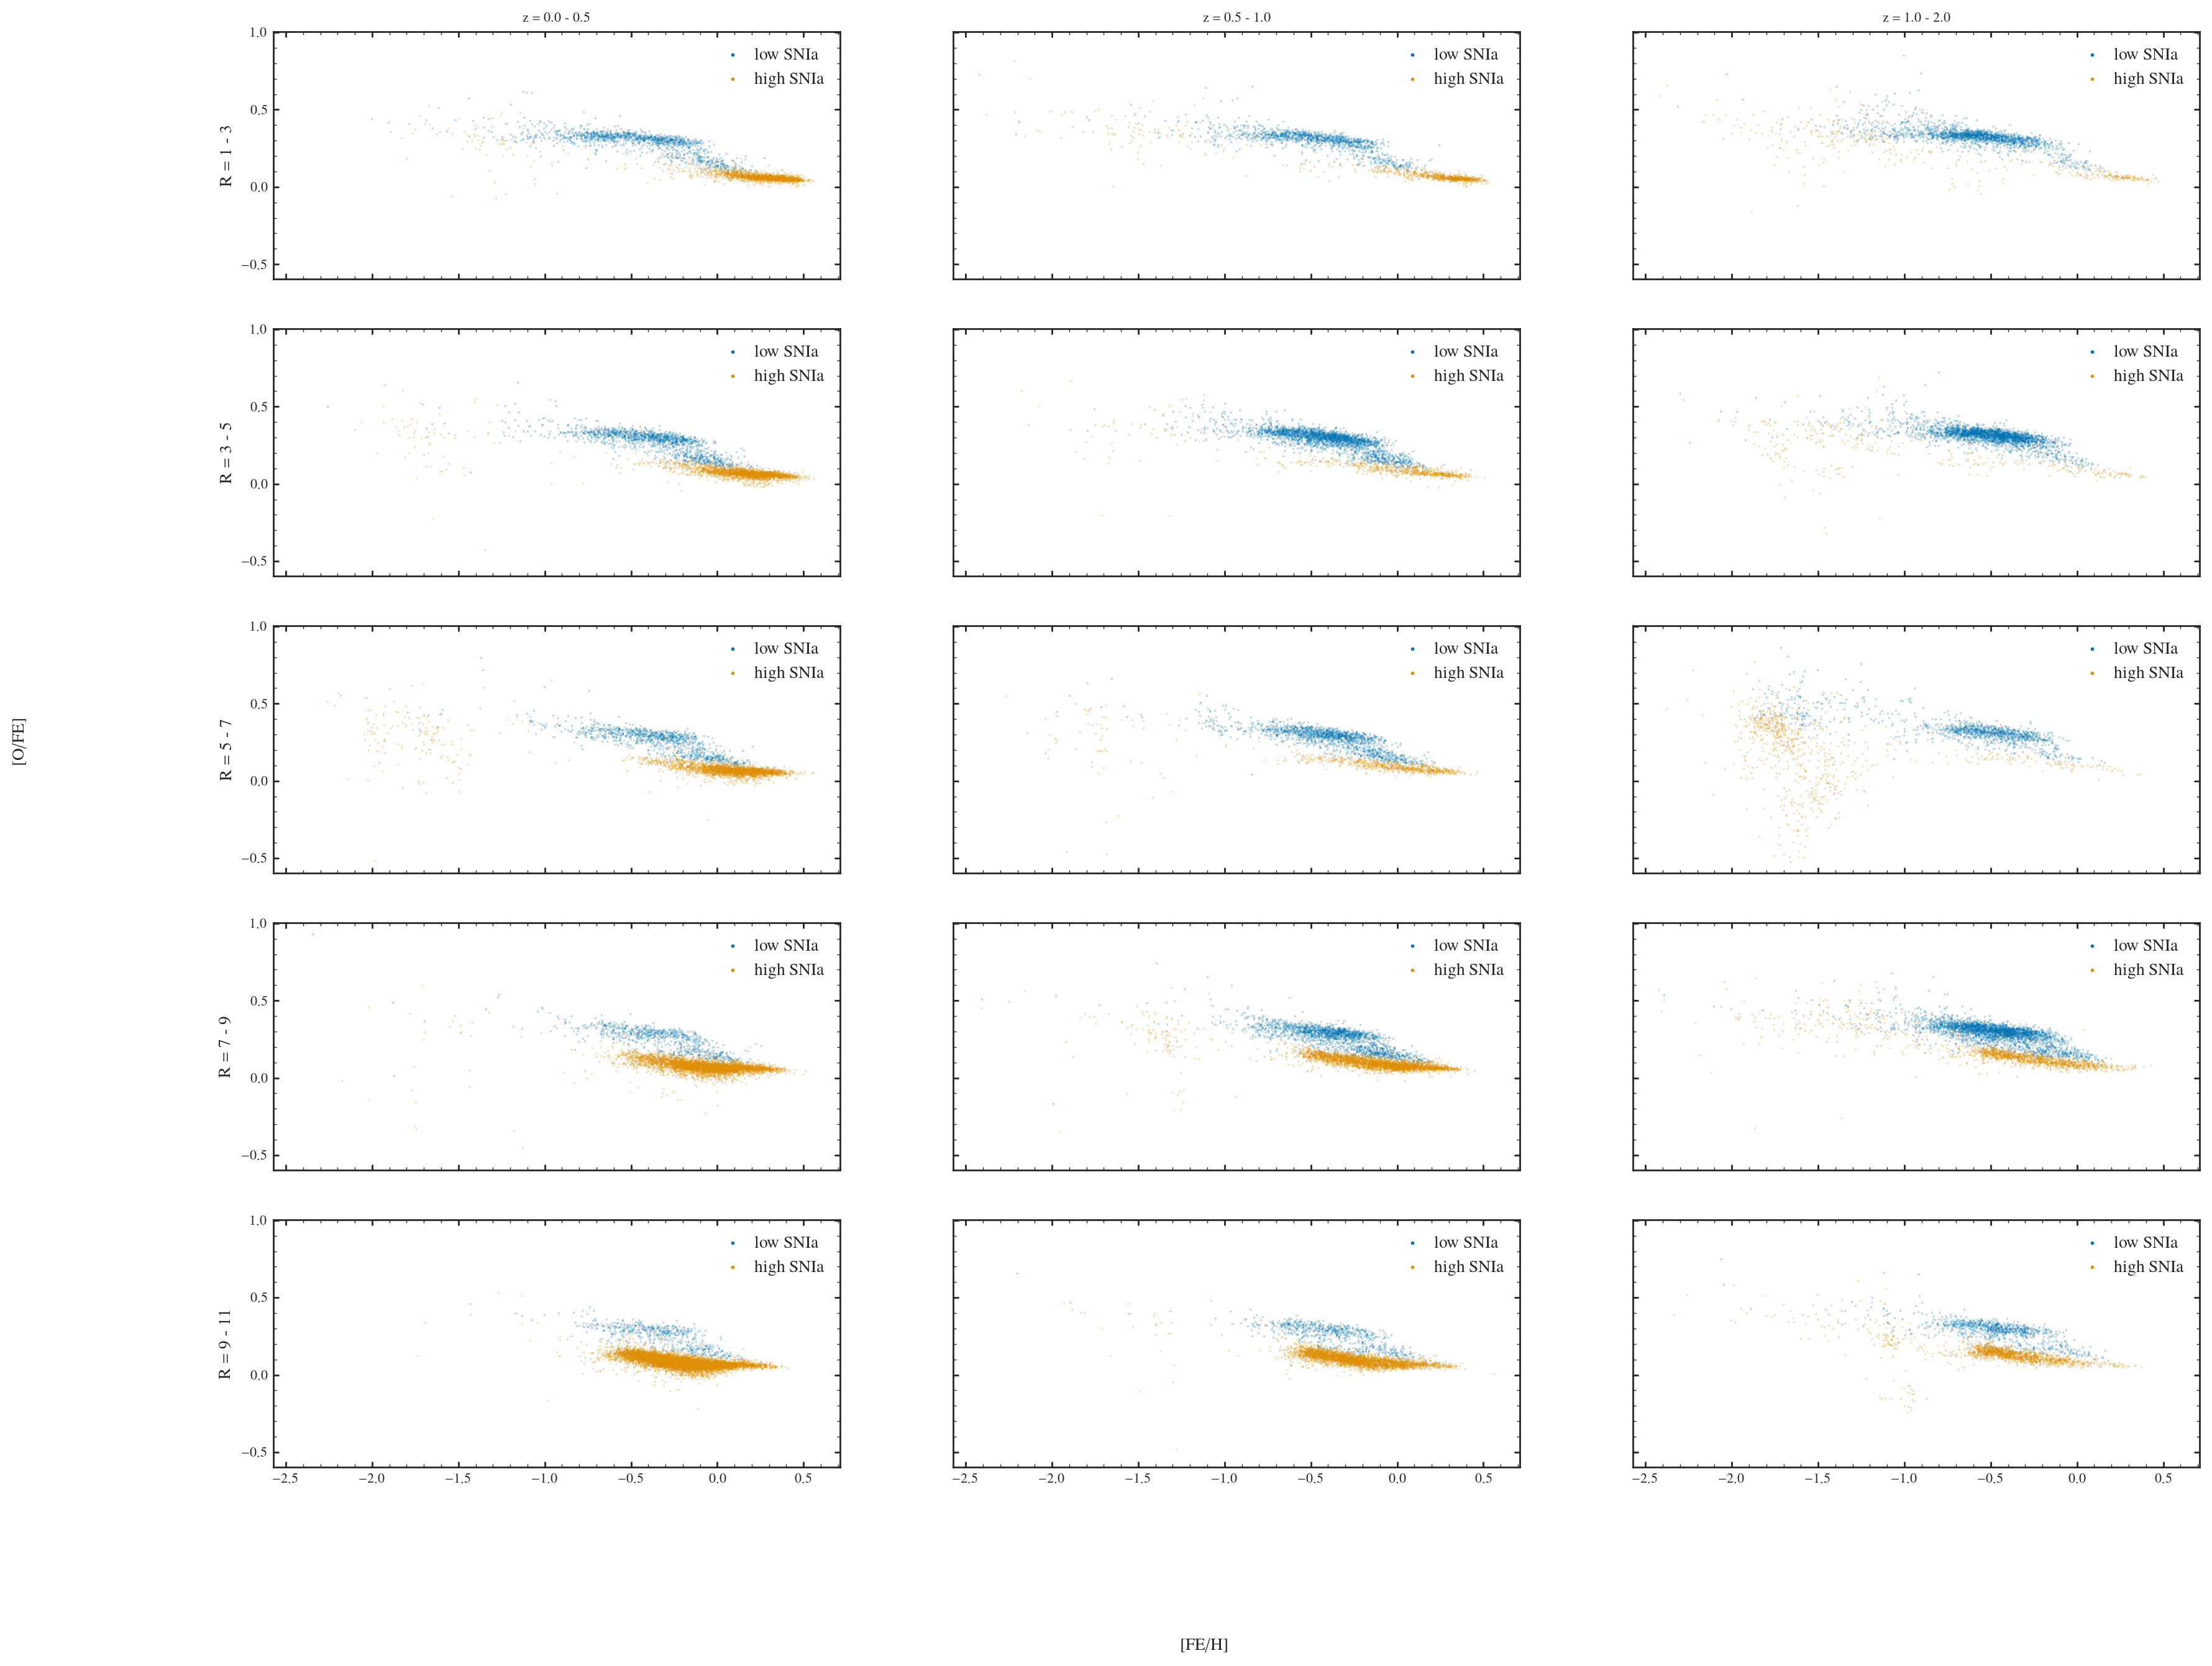

In [96]:
plot_in_gal_region(x = "FE_H", y="O_FE")